# Fine tuning for image classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Download dataset

https://www.kaggle.com/drscarlat/melanoma

## Data preprocessing

In [5]:
train_dir = "DermMel/train_sep"
validation_dir = "DermMel/valid"
test_dir = "DermMel/test"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 10682 files belonging to 2 classes.
Found 3562 files belonging to 2 classes.
Found 3561 files belonging to 2 classes.


In [6]:
print('Number of train batches: %d' % cardinality(train_dataset))
print('Number of validation batches: %d' % cardinality(validation_dataset))
print('Number of test batches: %d' % cardinality(test_dataset))

Number of train batches: 334
Number of validation batches: 112
Number of test batches: 112


# Show the first nine images and labels from the training set:

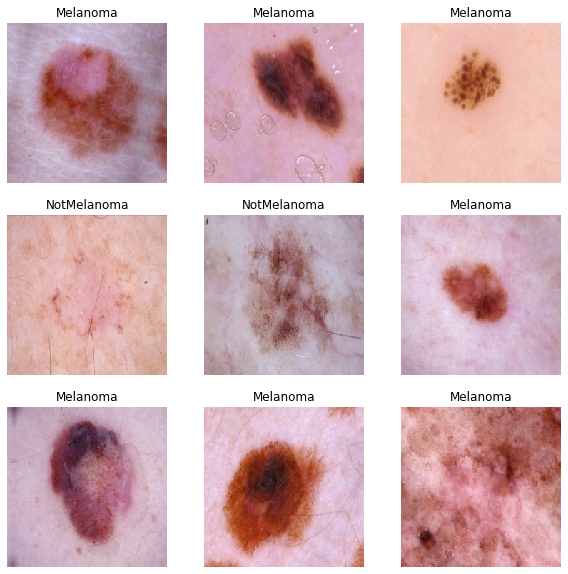

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

https://medium.com/featurepreneur/data-augmentation-using-keras-preprocessing-layers-6cdc7d49328e

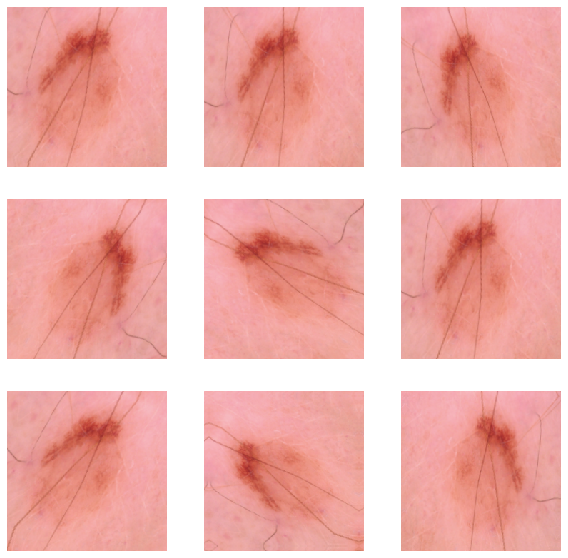

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Rescale pixel values

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained convnets

In [19]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


# Freeze the convolutional base

In [21]:
base_model.trainable = False

In [22]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Add a classification head

In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model


In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Train the model

In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

112/112 [==============================] - 24s 191ms/step - loss: 0.7271 - accuracy: 0.5098


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.73
initial accuracy: 0.51


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
334/334 [==============================] - 95s 274ms/step - loss: 0.4323 - accuracy: 0.7890 - val_loss: 0.2331 - val_accuracy: 0.9284
Epoch 2/10
334/334 [==============================] - 89s 266ms/step - loss: 0.2833 - accuracy: 0.8760 - val_loss: 0.2294 - val_accuracy: 0.9326
Epoch 3/10
334/334 [==============================] - 93s 278ms/step - loss: 0.2543 - accuracy: 0.8883 - val_loss: 0.2301 - val_accuracy: 0.9332
Epoch 4/10
334/334 [==============================] - 93s 278ms/step - loss: 0.2452 - accuracy: 0.8913 - val_loss: 0.2122 - val_accuracy: 0.9335
Epoch 5/10
334/334 [==============================] - 92s 276ms/step - loss: 0.2322 - accuracy: 0.9000 - val_loss: 0.2124 - val_accuracy: 0.9329
Epoch 6/10
334/334 [==============================] - 97s 289ms/step - loss: 0.2181 - accuracy: 0.9055 - val_loss: 0.2118 - val_accuracy: 0.9329
Epoch 7/10
334/334 [==============================] - 92s 276ms/step - loss: 0.2168 - accuracy: 0.9078 - val_loss: 0.2065 - val_ac

# Learning curves

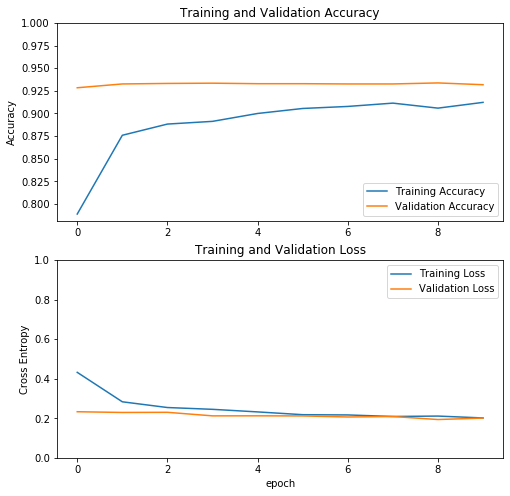

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Un-freeze the top layers of the model


In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [32]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile the model

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

C:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Continue training the model

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
334/334 [==============================] - 117s 332ms/step - loss: 0.1970 - accuracy: 0.9169 - val_loss: 0.1715 - val_accuracy: 0.9368
Epoch 11/20
334/334 [==============================] - 117s 347ms/step - loss: 0.1865 - accuracy: 0.9196 - val_loss: 0.1630 - val_accuracy: 0.9360
Epoch 12/20
334/334 [==============================] - 116s 347ms/step - loss: 0.1768 - accuracy: 0.9259 - val_loss: 0.1871 - val_accuracy: 0.9307
Epoch 13/20
334/334 [==============================] - 116s 347ms/step - loss: 0.1691 - accuracy: 0.9282 - val_loss: 0.1874 - val_accuracy: 0.9304
Epoch 14/20
334/334 [==============================] - 116s 346ms/step - loss: 0.1597 - accuracy: 0.9305 - val_loss: 0.1505 - val_accuracy: 0.9405
Epoch 15/20
334/334 [==============================] - 116s 347ms/step - loss: 0.1555 - accuracy: 0.9324 - val_loss: 0.1505 - val_accuracy: 0.9340
Epoch 16/20
334/334 [==============================] - 117s 350ms/step - loss: 0.1527 - accuracy: 0.9372 - val_loss: 0

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

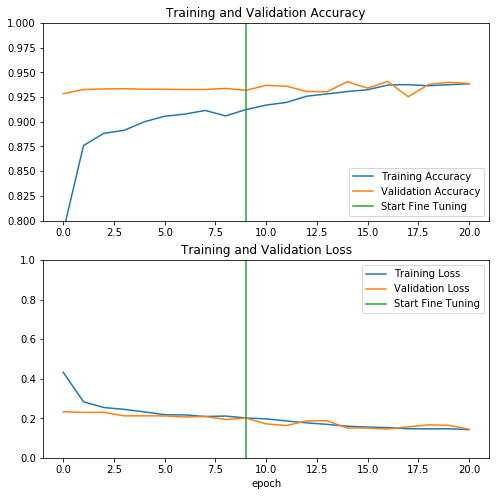

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and batch prediction

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

112/112 [==============================] - 24s 201ms/step - loss: 0.1613 - accuracy: 0.9298
Test accuracy : 0.9297950267791748


Predictions:
 [0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1]
Labels:
 [0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1]


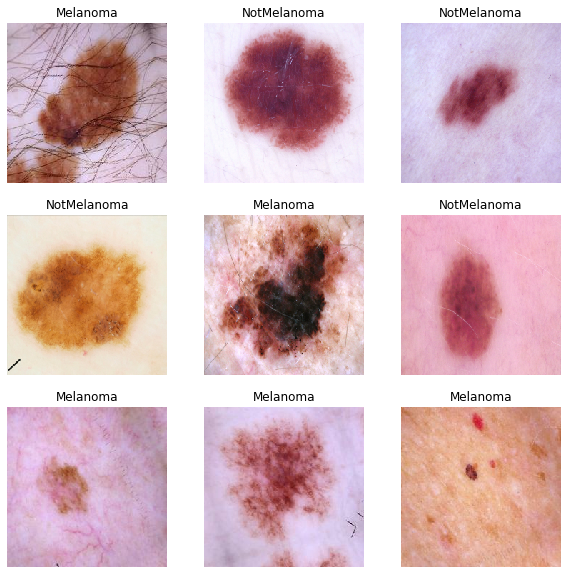

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Single prediction

In [44]:
from tensorflow.keras.preprocessing import image
img = image.load_img('test_image/unknown/AUG_0_162.jpeg', target_size = (224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [45]:
pred = model.predict(img)
pred = tf.nn.sigmoid(pred)
pred = tf.where(pred < 0.5, 0, 1)
pred = pred.numpy()
print(class_names[pred[0][0]])

Melanoma
